# Deep Learning Project2B - Part 2(ResNet)
## Abdul Wahab Akram - 18L-1845

## Note: The data is already augmented like Part 1

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
from keras.optimizers import SGD
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import applications
from os import listdir
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import numpy as np

## Variables Inialization
### Image Width = 150
### Image Height = 150

In [0]:
train_data = []
train_labels = []
test_data = []
test_labels = []
im_width = 150
im_height = 150
num_classes = 7

## Preprocessing Function

In [0]:
def preProcessTrainData(path):
    progress = 0
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    
    for file_name in image_files:
        image_file = str(path + file_name)
        
        img = cv2.imread(image_file,cv2.IMREAD_COLOR)
        new_img = cv2.resize(img,(im_width,im_height))
        train_data.append(new_img)
        progress = progress+1
        
        train_labels.append(int(path[-2])-1)
        
        if progress%1000==0:
            print('Progress '+str(progress)+' Image done of Disease type:'  + path[-2])

## Preprocess images by calling preprocess function

In [81]:
for i in range(7):
    preProcessTrainData(os.getcwd()+'/DermCNN/'+str(i+1)+'/')

Progress 1000 Image done of Disease type:1
Progress 1000 Image done of Disease type:2
Progress 1000 Image done of Disease type:3
Progress 1000 Image done of Disease type:4
Progress 1000 Image done of Disease type:5
Progress 1000 Image done of Disease type:6
Progress 1000 Image done of Disease type:7


## Converting train_data list to numpy array

In [82]:
train_data = np.array(train_data)
print(train_data.shape)

(11746, 150, 150, 3)


## Coverting train_labels list to numpy array

In [83]:
train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)
train_labels.shape

(11746,)

## Reshaping data and converting it between 0 and 1

In [0]:
train_data = train_data.reshape((train_data.shape)[0],(train_data.shape)[1],(train_data.shape)[2],3)
train_data.astype('float32')
#test_data = test_data.reshape((test_data.shape)[0],(test_data.shape)[1],(test_data.shape)[2],1)
#test_data.astype('float32')
train_data = train_data/255.0
#test_data = test_data/255.0

In [0]:
train_labels.astype('uint8')
#test_labels.astype('uint8')
train_labels = keras.utils.to_categorical(train_labels, num_classes)
#test_labels = keras.utils.to_categorical(test_labels, num_classes)z

## Function to shuffle data

In [0]:
def shuffle(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)



## Shuffling data and labels in unison

In [0]:
for i in range(10):
    shuffle(train_data,train_labels)
  #  shuffle(test_data,test_labels)

## Model 1

In [93]:
model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Freezing first 40 layers of model 1 and fine tuning the rest

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:40]:
   layer.trainable = False
for layer in model.layers[40:]:
   layer.trainable = True

## Adding custom dense layers along with softmax layer

In [ ]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dropout(0.35)(x)
x = Dense(200,activation="relu")(x)
x = Dropout(0.35)(x)
x = Dense(7,activation='softmax')(x)

# creating the final model 
model_final = Model(input = model.input, output = x)

## Compile and fit Model 1 - Validation Accuracy did not improve at all

In [95]:
model_final.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

history = model_final.fit(train_data,train_labels,
          batch_size=30,
          epochs=30,
          verbose=1,
          shuffle=True,
          validation_split=0.12)

Train on 10336 samples, validate on 1410 samples
Epoch 1/30
10336/10336 [==============================] - 192s 19ms/step - loss: 0.4531 - acc: 0.8640 - val_loss: 13.5002 - val_acc: 0.1624
Epoch 2/30
10336/10336 [==============================] - 162s 16ms/step - loss: 0.0660 - acc: 0.9804 - val_loss: 13.5003 - val_acc: 0.1624
Epoch 3/30
  660/10336 [>.............................] - ETA: 2:24 - loss: 0.0665 - acc: 0.9788

KeyboardInterrupt: ignored

### After Model 1, I tried many models like fine-tuning the last 30 layers, fine tuning the whole resnet50 and not fine-tuning at all, but my validation accuracy did not improve in any of these cases. Then I tried a model in which first 10 layers were fine-tuned and remaining were freezed, I got some better results with this model although it is not a recommended approach to fine-tune first layers and freeze the last ones but I got better results with this technique and I am not able to find yet why is this so.

## Model 2

In [96]:
model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


## Fine-Tuning first 10 layers and freezing the rest

In [ ]:
for layer in model.layers[:10]:
   layer.trainable = True
for layer in model.layers[10:]:
   layer.trainable = False

## Adding custom dense layers along with softmax layer

In [ ]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dropout(0.35)(x)
x = Dense(200,activation="relu")(x)
x = Dropout(0.35)(x)
x = Dense(7,activation='softmax')(x)

# creating the final model 
model_final = Model(input = model.input, output = x)



## Compile and Fit Model: Highest Validation Accuracy = 87.38 at 3rd epoch

In [97]:
model_final.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])
history = model_final.fit(train_data,train_labels,
          batch_size=30,
          epochs=30,
          verbose=1,
          shuffle=True,
          validation_split=0.12)

Train on 10336 samples, validate on 1410 samples
Epoch 1/30
10336/10336 [==============================] - 152s 15ms/step - loss: 0.6657 - acc: 0.7931 - val_loss: 0.4900 - val_acc: 0.8383
Epoch 2/30
10336/10336 [==============================] - 124s 12ms/step - loss: 0.1489 - acc: 0.9499 - val_loss: 0.5553 - val_acc: 0.8539
Epoch 3/30
10336/10336 [==============================] - 124s 12ms/step - loss: 0.0924 - acc: 0.9701 - val_loss: 0.4595 - val_acc: 0.8738
Epoch 4/30
10336/10336 [==============================] - 124s 12ms/step - loss: 0.0589 - acc: 0.9808 - val_loss: 0.6418 - val_acc: 0.8504
Epoch 5/30
10336/10336 [==============================] - 124s 12ms/step - loss: 0.0413 - acc: 0.9860 - val_loss: 0.5630 - val_acc: 0.8716
Epoch 6/30
10336/10336 [==============================] - 124s 12ms/step - loss: 0.0437 - acc: 0.9857 - val_loss: 1.6934 - val_acc: 0.6872
Epoch 7/30
10336/10336 [==============================] - 124s 12ms/step - loss: 0.0496 - acc: 0.9838 - val_loss: 0.7

## Epoch vs Loss Plot

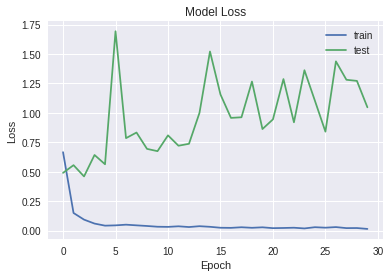

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Epoch vs Accuracy Plot

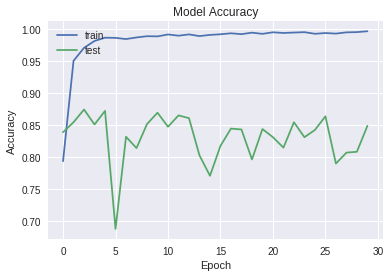

In [99]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## I am not satisfied with results of ResNet50 but I tried many things and searched for my problem but was not able to find any solutions.